# Загрузка данных

Импорт и установка библиотек

In [37]:
!pip install pmdarima
# !pip install numpy==1.26.4
!pip install keras-tuner

from pmdarima import auto_arima
import pickle
import warnings
import requests
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from io import BytesIO
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import acf, adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA



warnings.filterwarnings("ignore")
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


Выберите способ загрузки данных

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')

In [3]:
# df_ts = pd.read_excel('/content/drive/MyDrive/int/train.xlsx')

# Анализ и предобработка

### просмотр статистической информации

In [4]:
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [5]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [6]:
# Проверка на наличие NaN
df_ts['dt'].isna().sum()

0

In [7]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [8]:
df_ts.shape

(400, 2)

### Визуализация

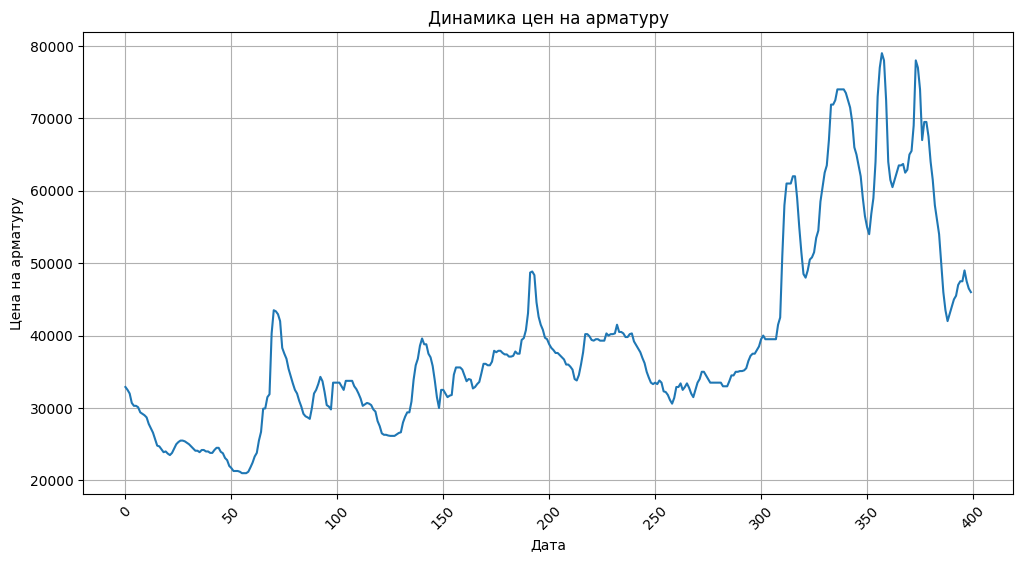

In [9]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

**Вопросы к графику:**

 1.Есть ли тренд?

 2.Есть ли сезонность?

 3.Насколько сильный шум?



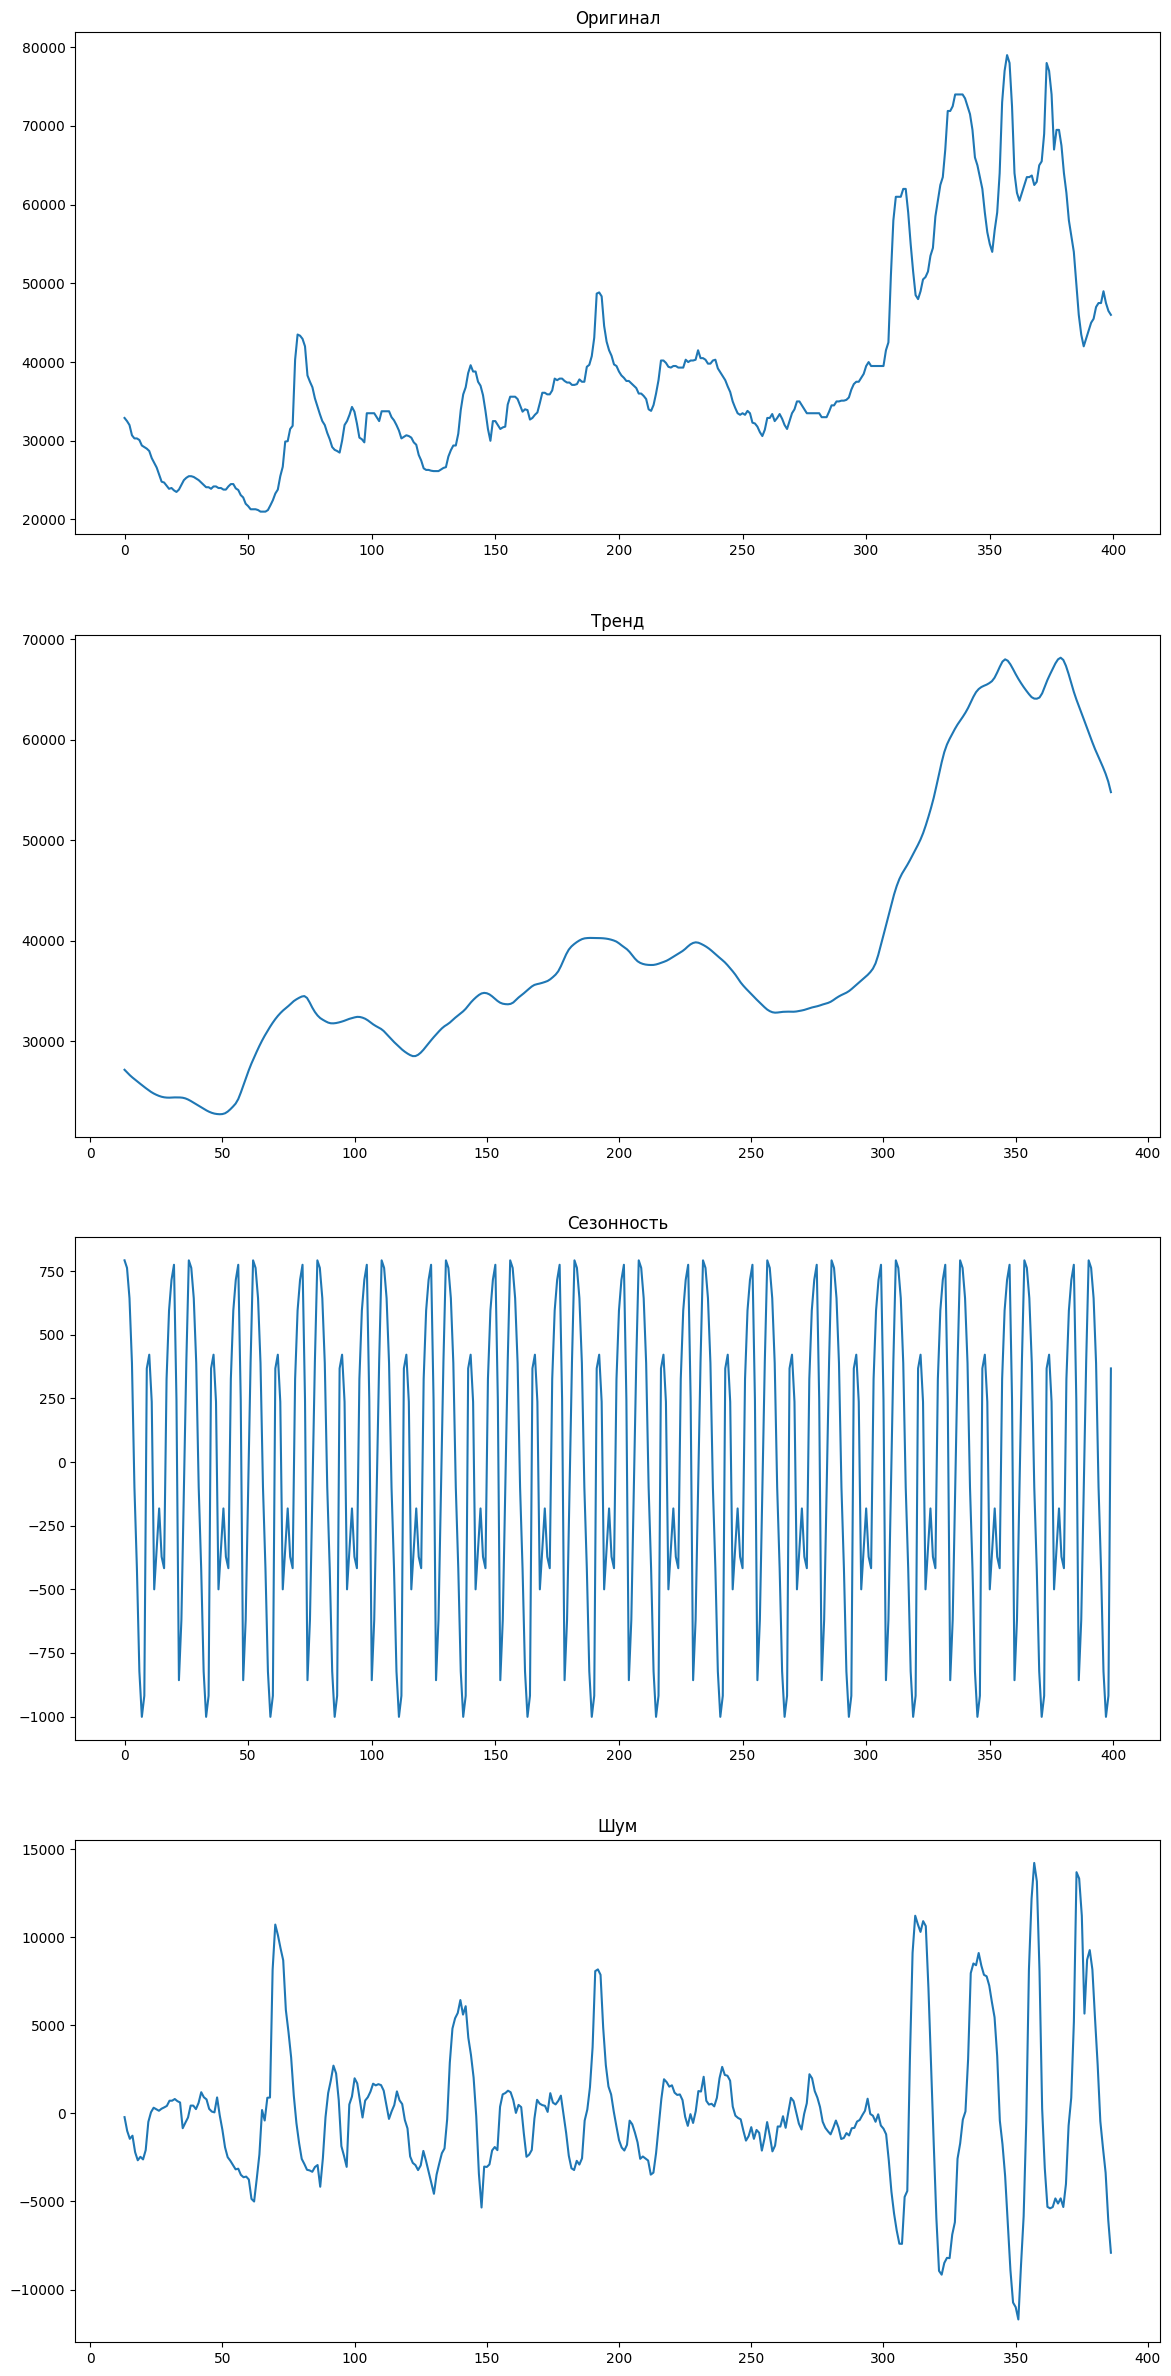

In [10]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 30))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 26)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

Декомпозиция временного ряда


🔹 Оригинальный ряд  


Исходные данные, содержащие тренд, сезонность и шум.


 📈 Тренд

   
Общий восходящий тренд, отражающий долгосрочный рост.


🔄 Сезонность


Выраженные периодические колебания, сохраняющиеся на протяжении всего ряда.


 🔀 Шум  

Умеренный, но увеличивается ближе к концу ряда, что может указывать на аномалии или возрастание волатильности.


### Работа с автокорреляцией

In [11]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

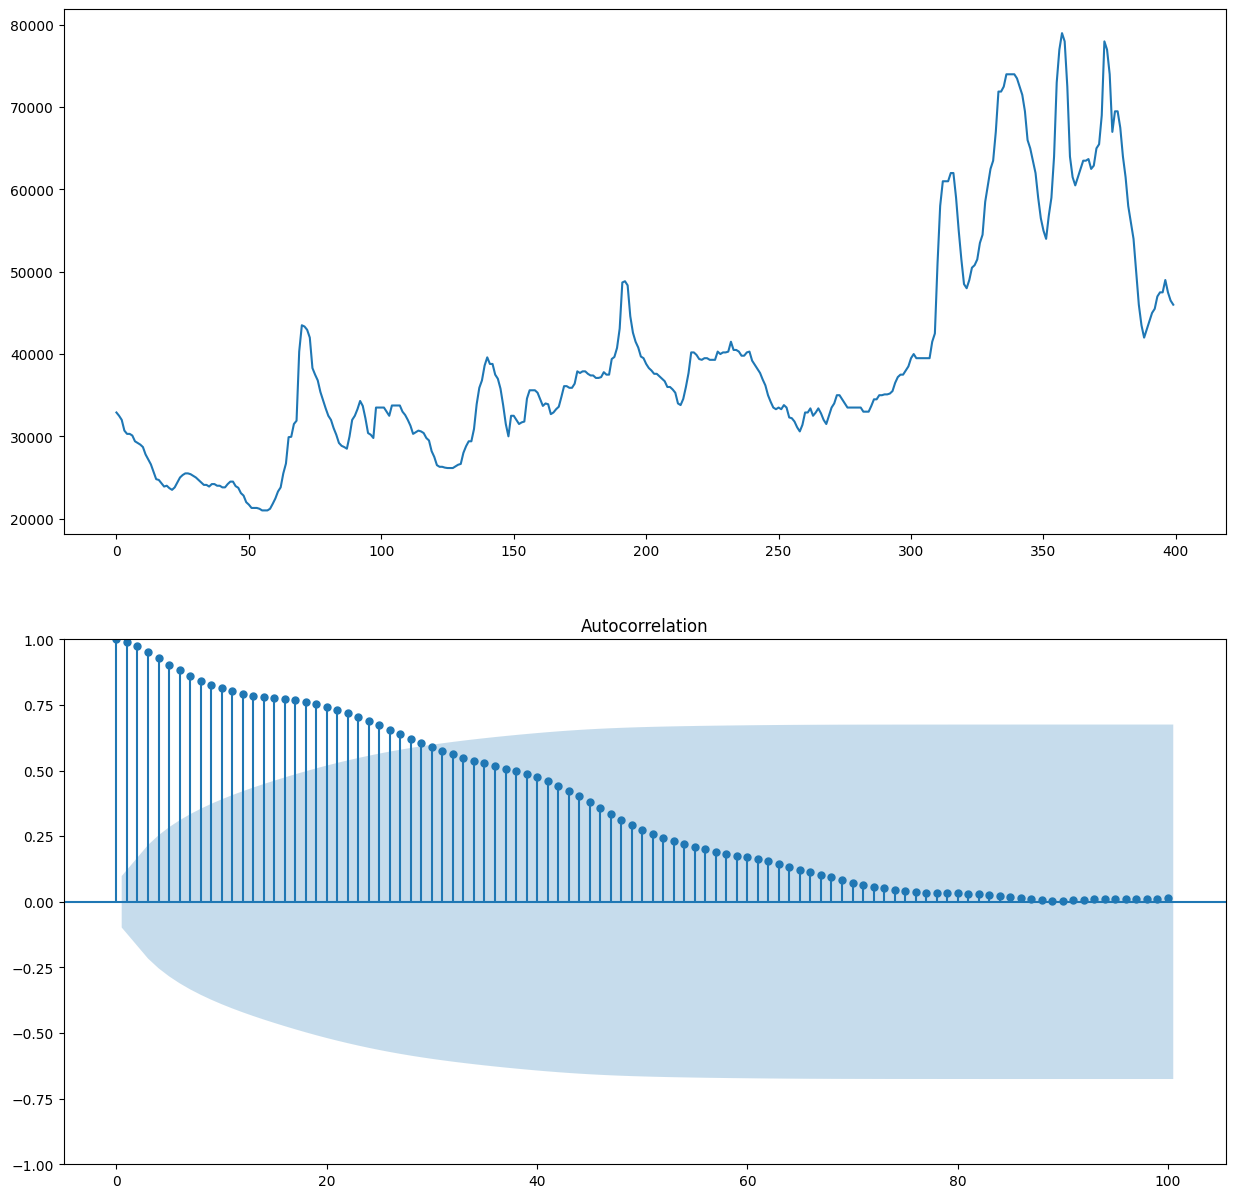

In [12]:
# Визуализация автокорреляции
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

Высокая корреляция на малых лагах указывает на сильную зависимость текущих значений от предыдущих.

Корреляция постепенно уменьшается с увеличением лага, что характерно для многих временных рядов.


Светло-синяя область – это доверительный интервал: значения внутри него можно считать статистически незначимыми.

In [13]:
# проверка на стационарность первоначального ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру'])

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Critical Values: {'1%': -3.4470566389664703, '5%': -2.8689037160476016, '10%': -2.570692663557422}
Ряд нестационарен (p-value >= 0.05)


Text(0.5, 1.0, 'Распределение цен на арматуру')

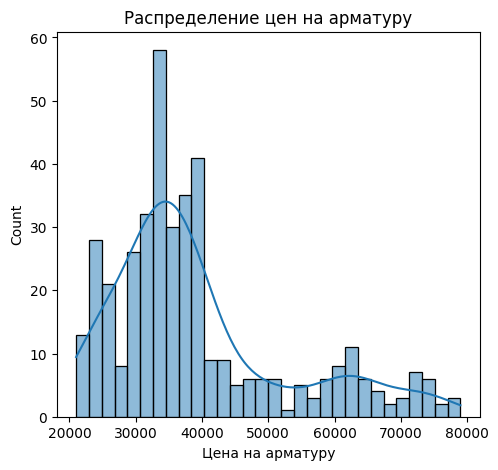

In [14]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")


На графики видем что большинство значений  примерно сосредоточено между 30тыс и 40тыс

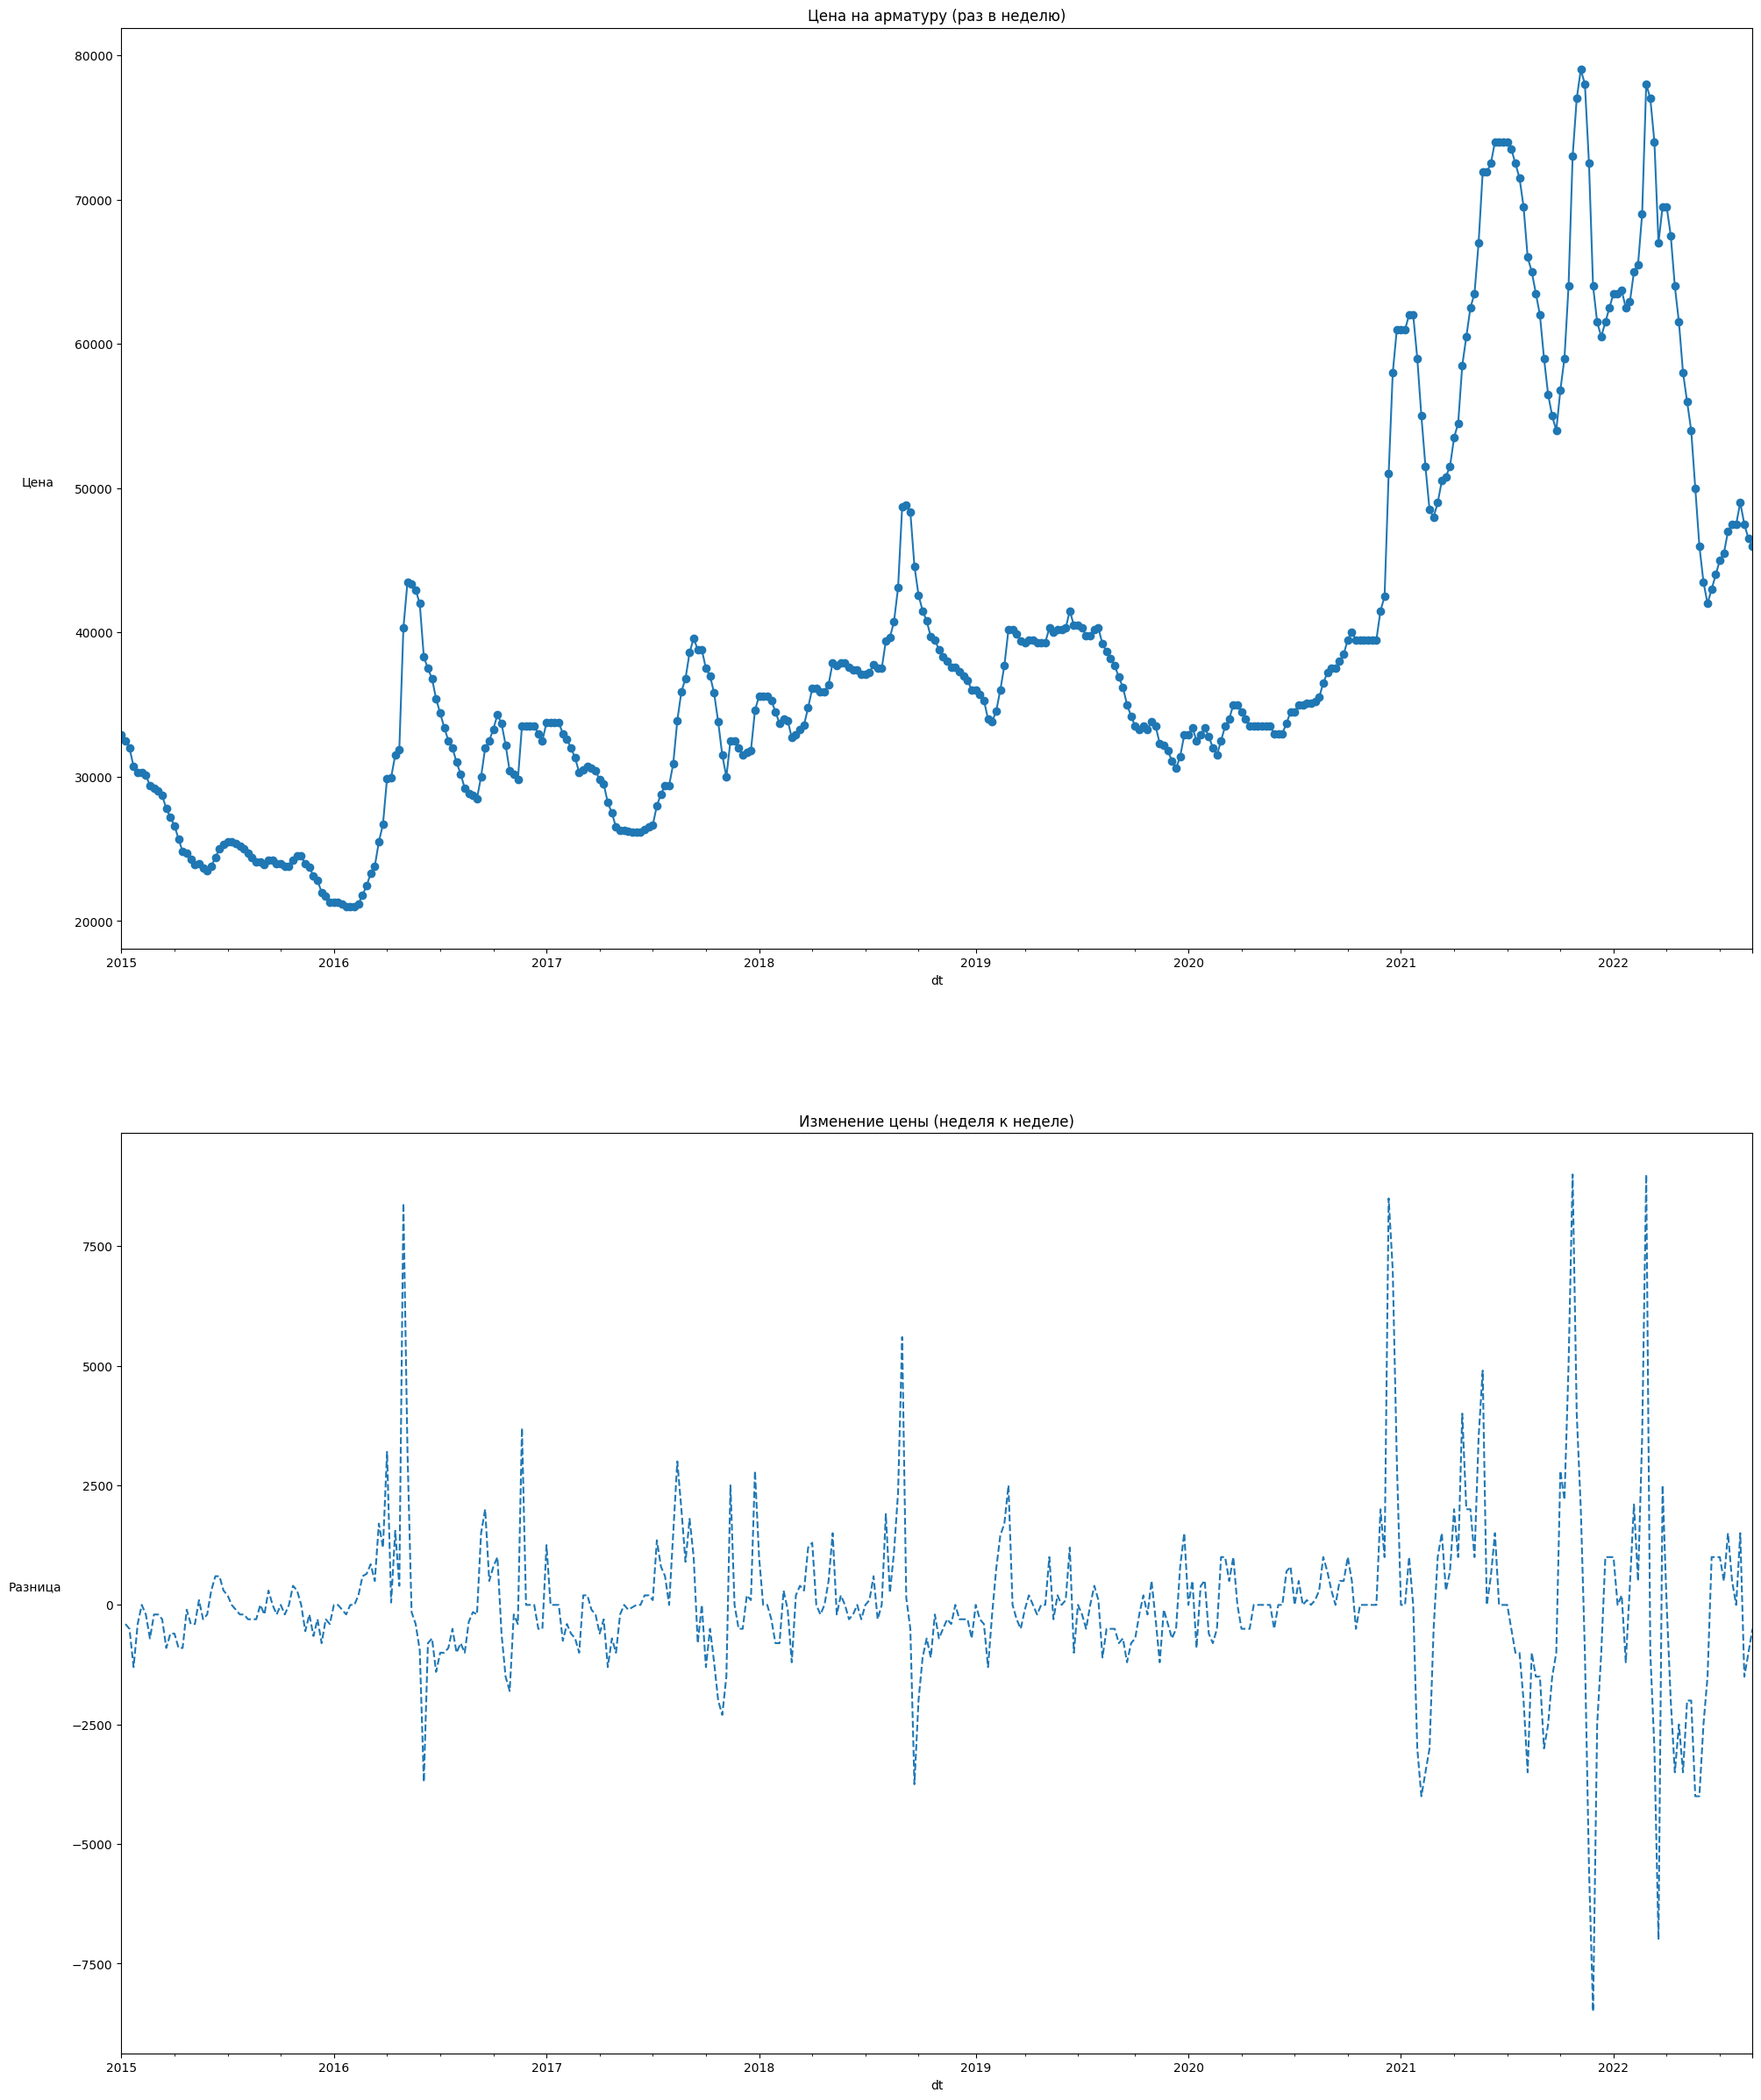

In [15]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 30))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()


1. Верхний график – временной ряд цен на аренду.

Видно наличие тренда: долгосрочный рост цен с колебаниями.

Наблюдаются всплески и падения, возможно, сезонные или вызванные внешними факторами.

В последние годы цены достигли пиковых значений, а затем начали снижаться.
___


2. Нижний график – изменения цен (разность цен между соседними точками).

Колебания вокруг нуля указывают на стационарность изменений.

Присутствуют резкие всплески, что говорит о периодах высокой волатильности.

Возможно, есть влияние новостей, кризисов или других внешних событий.



In [16]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dt                   400 non-null    datetime64[ns]
 1   Цена на арматуру     400 non-null    int64         
 2   Цена_разница_неделя  399 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 9.5 KB


In [17]:
df_ts.replace(np.nan, 0, inplace=True)

In [18]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [19]:
# проверка на стационарность diff ряда
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена_разница_неделя'])

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Critical Values: {'1%': -3.447360865754795, '5%': -2.8690374364690445, '10%': -2.5707639493486636}
Ряд стационарен (p-value < 0.05)


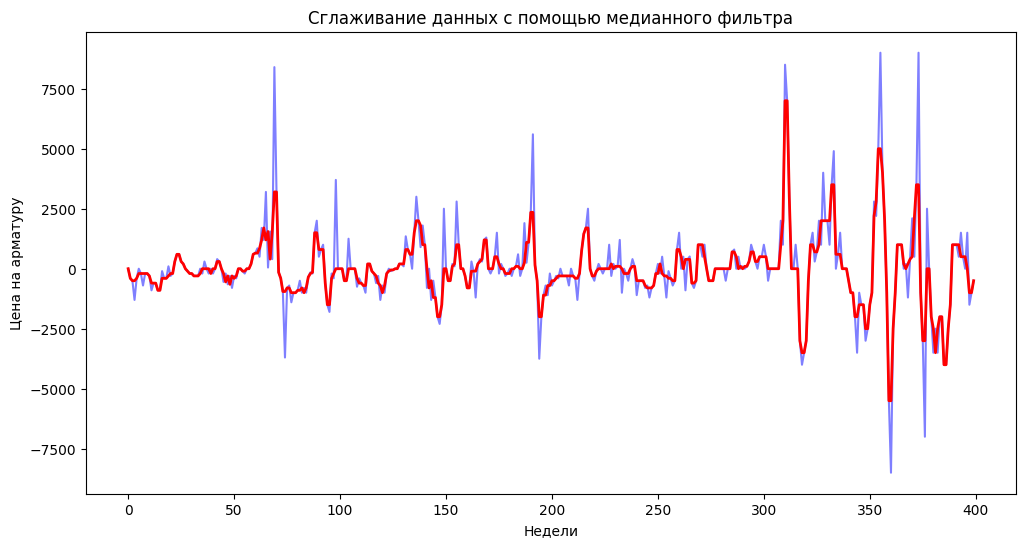

In [20]:
from scipy.signal import medfilt

# Применение медианного фильтра
df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=3)

# Построение графика
plt.figure(figsize=(12, 6))

# Исходные данные
plt.plot(df_ts.index, df_ts["Цена_разница_неделя"], label="Исходные данные", color='blue', alpha=0.5)

# Сглаженные данные
plt.plot(df_ts.index, df_ts["Цена на арматуру (сглаженная)"], label="Сглаженные данные", color='red', linewidth=2)

# Настройка графика
plt.title("Сглаживание данных с помощью медианного фильтра")
plt.xlabel("Недели")
plt.ylabel("Цена на арматуру")
plt.show()

In [21]:
# проверка на стационарность diff ряда после сглаживания
# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])

ADF Statistic: -8.108679715553967
p-value: 1.2427490594539653e-12
Critical Values: {'1%': -3.447099431978147, '5%': -2.8689225261604263, '10%': -2.57070269105012}
Ряд стационарен (p-value < 0.05)


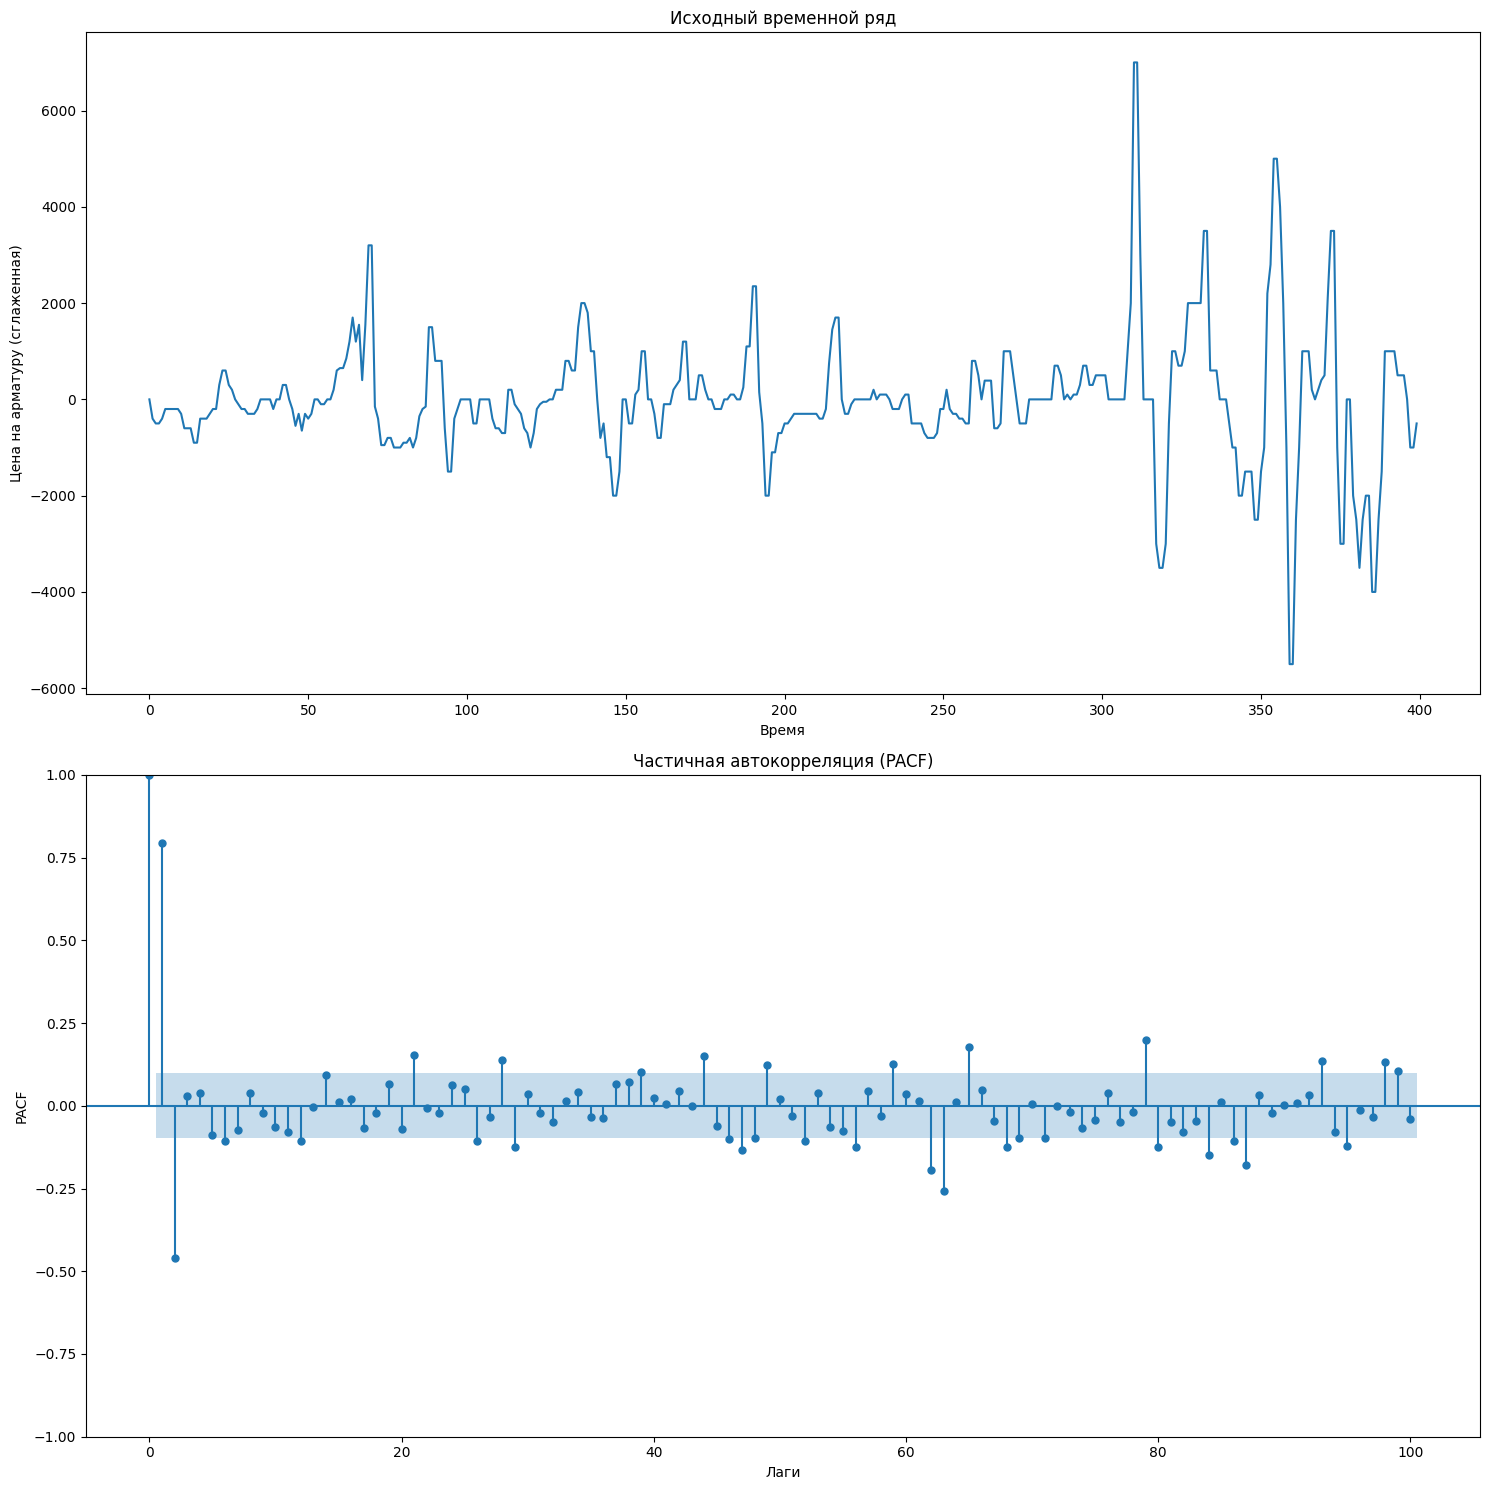

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# Создаем график с двумя подграфиками
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Первый подграфик: исходный временной ряд
df_ts['Цена на арматуру (сглаженная)'].plot(ax=ax[0])
ax[0].set_title('Исходный временной ряд')
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Цена на арматуру (сглаженная)')

# Второй подграфик: PACF (частичная автокорреляция)
plot_pacf(df_ts['Цена на арматуру (сглаженная)'], lags=100, ax=ax[1], method='ols')
ax[1].set_title('Частичная автокорреляция (PACF)')
ax[1].set_xlabel('Лаги')
ax[1].set_ylabel('PACF')

# Отображаем график
plt.tight_layout()
plt.show()

1. Верхний график (исходный временной ряд):

Хотя он выглядит волатильным, после проверки на стационарность можно сказать, что данные не содержат явного тренда.

Это значит, что применённые преобразования (медианное сглаживание и дифференцирование) сделали ряд пригодным для моделирования.

Колебания могут указывать на сезонность или авторегрессию.

___

2. Нижний график (PACF):

Высокое значение на первом лаге говорит о сильной краткосрочной зависимости в данных.

Дальнейшие значения колеблются вокруг 0, но есть несколько значимых пиков. Это может указывать на авторегрессионный процесс (AR), возможно, порядка 1 или 2.

Учитывая стационарность, можно попробовать модель AR(p), где p — это порядок, определяемый по PACF (например, если есть значимые пики на 1 и 2 лагах, можно взять AR(2)).


# Модели

### Линейная регрессия

Средняя абсолютная ошибка (MAE): 1725.21
Корень среднеквадратичной ошибки (RMSE): 2206.64
Симметричная MAPE (SMAPE): 165.57%
Средняя точность направления (MDA): 0.33


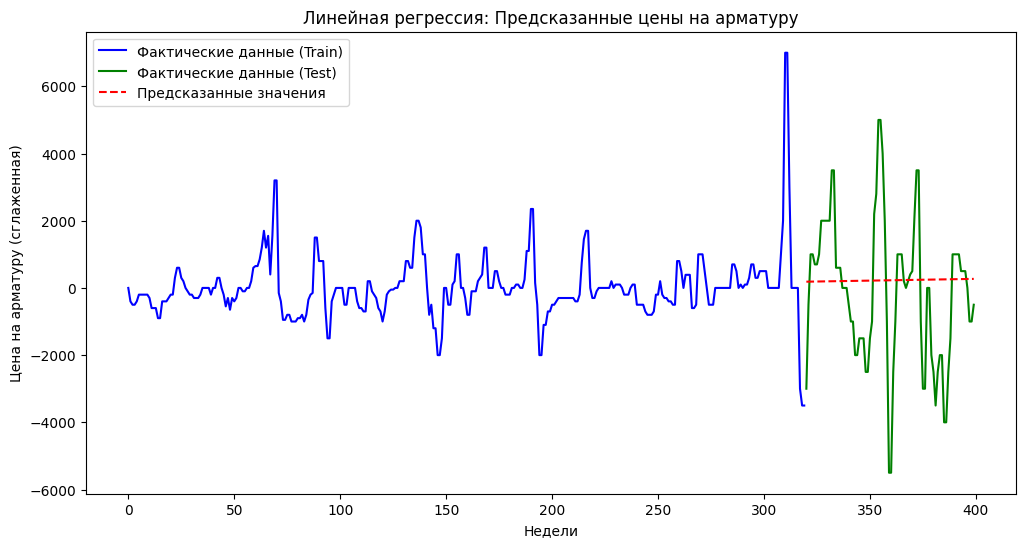

In [23]:
# 2. Предобработка данных
df_ts["weeks"] = (df_ts["dt"] - df_ts["dt"].min()).dt.days // 7  # Преобразуем дату в количество недель

# 3. Определение признаков (X) и целевой переменной (y)
X = df_ts[["weeks"]]  # Количество недель с первой даты
y = df_ts["Цена на арматуру (сглаженная)"]  # Цены на арматуру

# Разделение данных на обучающую и тестовую выборки
split_index = int(len(X) * 0.8)
X_train_lr, X_test_lr = X[:split_index], X[split_index:]
y_train_lr, y_test_lr = y[:split_index], y[split_index:]

# 5. Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

# 6. Получение предсказаний
y_pred_lr = model.predict(X_test_lr)

# 7. Оценка качества модели

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test_lr, y_pred_lr)

# Корень среднеквадратичной ошибки (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))

# Симметричная MAPE (SMAPE)
smape = np.mean(2 * np.abs(y_test_lr - y_pred_lr) / (np.abs(y_test_lr) + np.abs(y_pred_lr))) * 100

# Средняя точность направления (MDA) с выравниванием индексов
y_test = y_test_lr.diff().dropna()
y_pred = pd.Series(y_pred_lr, index=y_test_lr.index)

# Убираем несовпадающие индексы
common_index = y_test.index.intersection(y_pred.index)

mda = np.mean(np.sign(y_test.loc[common_index]) == np.sign(y_pred.loc[common_index]))

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape:.2f}%")
print(f"Средняя точность направления (MDA): {mda:.2f}")


# 9. Визуализация результатов
plt.figure(figsize=(12, 6))

# Линия фактических данных (Train)
plt.plot(X_train_lr, y_train_lr, color="blue", label="Фактические данные (Train)")

# Линия фактических данных (Test)
plt.plot(X_test_lr, y_test_lr, color="green", label="Фактические данные (Test)")

# Линия предсказаний (Test)
plt.plot(X_test_lr, y_pred_lr, color="red", linestyle="dashed", label="Предсказанные значения")

plt.xlabel("Недели")
plt.ylabel("Цена на арматуру (сглаженная)")
plt.title("Линейная регрессия: Предсказанные цены на арматуру")
plt.legend()
plt.show()

### Arima

In [24]:
!pip install pmdarima


In [25]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [26]:
# Разделим данные на тренировочные и тестовые выборки (80%/20%)
train_size_a = int(len(df_ts) * 0.8)
train_a, test_a = df_ts['Цена на арматуру (сглаженная)'][:train_size_a], df_ts['Цена на арматуру (сглаженная)'][train_size_a:]

# Применим auto_arima для подбора модели ARIMA
model = auto_arima(train_a, seasonal=False, stepwise=True, trace=True)

# Выводим информацию о лучшей модели
print(f"Лучшие параметры ARIMA: {model.order}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4960.120, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5314.108, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5012.833, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5087.915, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4962.189, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4965.332, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4959.610, Time=1.15 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4967.031, Time=1.74 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=4961.644, Time=2.66 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=3.94 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4960.097, Time=1.85 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4960.760, Time=1.28 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=4.70 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4961.691, Time=2.75 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]       

In [27]:

# Функция для выполнения теста ADF
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")

    if result[1] < 0.05:
        print("Ряд стационарен (p-value < 0.05)")
    else:
        print("Ряд нестационарен (p-value >= 0.05)")
# Проверим на стационарность исходный ряд
adf_test(df_ts['Цена на арматуру (сглаженная)'])

ADF Statistic: -8.108679715553967
p-value: 1.2427490594539653e-12
Critical Values: {'1%': -3.447099431978147, '5%': -2.8689225261604263, '10%': -2.57070269105012}
Ряд стационарен (p-value < 0.05)


In [29]:
# Выбираем столбец с данными временного ряда
time_series_a = df_ts['Цена на арматуру (сглаженная)']
model = ARIMA(time_series_a, order= model.order )
fitted_model = model.fit()


MAE: 769.0646
RMSE: 1098.8027
SMAPE: 75.17%
MDA: 81.01%


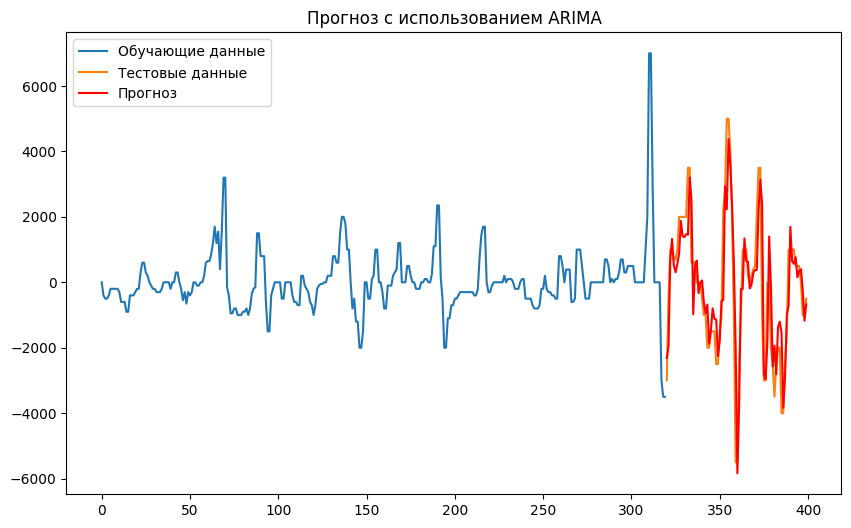

In [30]:
# Прогнозируем на тестовых данных
forecast = fitted_model.predict(start=len(train_a), end=len(train_a) + len(test_a) - 1)

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(test_a, forecast)
print(f"MAE: {mae:.4f}")

#  Корень среднеквадратичной ошибки (RMSE)
rmse = np.sqrt(mean_squared_error(test_a, forecast))
print(f"RMSE: {rmse:.4f}")

# Симметричная MAPE (SMAPE)
smape = np.mean(2 * np.abs(forecast - test_a) / (np.abs(test_a) + np.abs(forecast))) * 100
print(f"SMAPE: {smape:.2f}%")

# Сдвигаем массивы на один элемент
test_a_shifted = test_a[:-1]
forecast_shifted = forecast[:-1]

# Вычисляем MDA
mda = np.mean(np.sign(test_a_shifted) == np.sign(forecast_shifted))
print(f"MDA: {mda:.2%}")



# Визуализируем результат
plt.figure(figsize=(10, 6))
plt.plot(train_a, label='Обучающие данные')
plt.plot(test_a, label='Тестовые данные')
plt.plot(forecast, label='Прогноз', color='red')
plt.legend()
plt.title('Прогноз с использованием ARIMA')
plt.show()

### SARIMA

                                      SARIMAX Results                                       
Dep. Variable:        Цена на арматуру (сглаженная)   No. Observations:                  320
Model:             SARIMAX(4, 0, 3)x(2, 1, [1], 20)   Log Likelihood               -2355.789
Date:                              Fri, 21 Mar 2025   AIC                           4733.577
Time:                                      08:19:10   BIC                           4774.319
Sample:                                           0   HQIC                          4749.882
                                              - 320                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.1945      0.400      5.491      0.000       1.411       2.978
ar.L2         -2.35

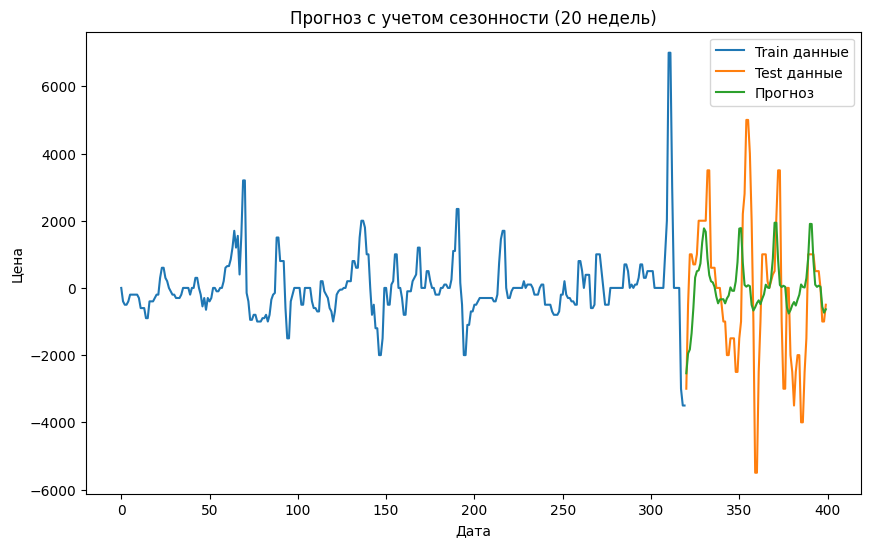

In [45]:
# Создание и обучение модели SARIMA с заданными параметрами
model = SARIMAX(
    train_a,
    order=(4, 0, 3),              # Несезонные параметры (p, d, q)
    seasonal_order=(2, 1, 1, 20)  # Сезонные параметры (P, D, Q, m)
)
results = model.fit()

# Вывод результатов обучения
print(results.summary())

# Прогнозирование на test данные
forecast = results.get_forecast(steps=len(test_a)).predicted_mean

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(train_a.index, train_a, label='Train данные')  # Обучающие данные
plt.plot(test_a.index, test_a, label='Test данные')    # Фактические значения test данных
plt.plot(test_a.index, forecast, label='Прогноз')    # Прогноз модели
plt.title('Прогноз с учетом сезонности (20 недель)')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

### LSTM

In [31]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# Разделение на train/test
train_size_lstm = int(len(df_ts) * 0.8)
train_lstm, test_lstm = df_ts.iloc[:train_size_lstm], df_ts.iloc[train_size_lstm:]

# Функция для создания окон временного ряда
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length].values)
    return np.array(X), np.array(y)

seq_length = 30  # Длина окна

# Создаем последовательности *только из test_lstm*
X_train, y_train = create_sequences(train_lstm[["Цена на арматуру (сглаженная)"]], seq_length)
X_test, y_test = create_sequences(test_lstm[["Цена на арматуру (сглаженная)"]], seq_length)

In [32]:
# Изменяем форму данных для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [33]:
# Создание модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0385 - val_loss: 0.0376
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0103 - val_loss: 0.0375
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0083 - val_loss: 0.0367
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0107 - val_loss: 0.0374
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0088 - val_loss: 0.0357
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - val_loss: 0.0357
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065 - val_loss: 0.0351
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0075 - val_loss: 0.0352
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0068 - val_loss: 0.0347
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0087 - val_loss: 0.0337
Epoch 11/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0079 - val_loss: 0.0335
Epoch 12/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

In [40]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Функция для подбора гиперпараметров
def build_model(hp):
    model = Sequential()

    # Первый слой LSTM
    model.add(LSTM(
        units=hp.Int('units_1', min_value=32, max_value=128, step=16),
        return_sequences=True,
        input_shape=(seq_length, 1),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))
    model.add(BatchNormalization())

    # Второй слой LSTM
    model.add(LSTM(
        units=hp.Int('units_2', min_value=32, max_value=128, step=16),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.5, step=0.1)))

    # Полносвязные слои
    model.add(Dense(hp.Int('dense_units', 10, 50, step=10), activation="relu"))
    model.add(Dense(1))

    # Компиляция модели
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss="mse"
    )

    return model

# Использование Keras Tuner для подбора гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="lstm_tuning"
)

# Коллбэки для остановки при переобучении
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Поиск лучших параметров
tuner.search(X_train, y_train, validation_data=(X_test, y_test),
             epochs=20, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1)

# Выбор наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение модели с лучшими параметрами
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=20, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=1)

Trial 90 Complete [00h 00m 17s]
val_loss: 0.12999720871448517

Best val_loss So Far: 0.018687164410948753
Total elapsed time: 00h 21m 56s
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1067 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0407 - val_loss: 0.1206 - learning_rate: 0.0010
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0239 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0186 - val_loss: 0.0973 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0179 - val_loss: 0.0924 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0146 - val_loss: 0.0836 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0147 - val_loss: 0.0759 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0143 - val_loss: 0.0706 - learning_rat

In [43]:
# Предсказания модели
y_pred = best_model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Преобразуем y_test в Series с индексами
y_test_series = pd.Series(y_test_inv.flatten())

# 1. Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

# 2. Корень среднеквадратичной ошибки (RMSE)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# 3. Симметричная MAPE (SMAPE)
smape = np.mean(2 * np.abs(y_test_inv - y_pred_inv) / (np.abs(y_test_inv) + np.abs(y_pred_inv))) * 100

# Проверяем, совпадают ли размеры массивов
if len(y_pred_inv.flatten()) != len(y_test_series):
    raise ValueError(f"Размеры y_pred_inv ({len(y_pred_inv.flatten())}) и y_test ({len(y_test_series)}) не совпадают!")

# Если размеры совпадают, создаем pd.Series с индексами y_test_series
y_pred = pd.Series(y_pred_inv.flatten(), index=y_test_series.index)

common_index = y_test_series.index.intersection(y_pred.index)

# 4. Средняя точность направления (MDA)
mda = np.mean(np.sign(y_test_series) == np.sign(y_pred))

# Вывод метрик
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Симметричная MAPE (SMAPE): {smape:.2f}%")
print(f"Средняя точность направления (MDA): {mda:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Средняя абсолютная ошибка (MAE): 1749.04
Корень среднеквадратичной ошибки (RMSE): 2290.65
Симметричная MAPE (SMAPE): 118.72%
Средняя точность направления (MDA): 0.55


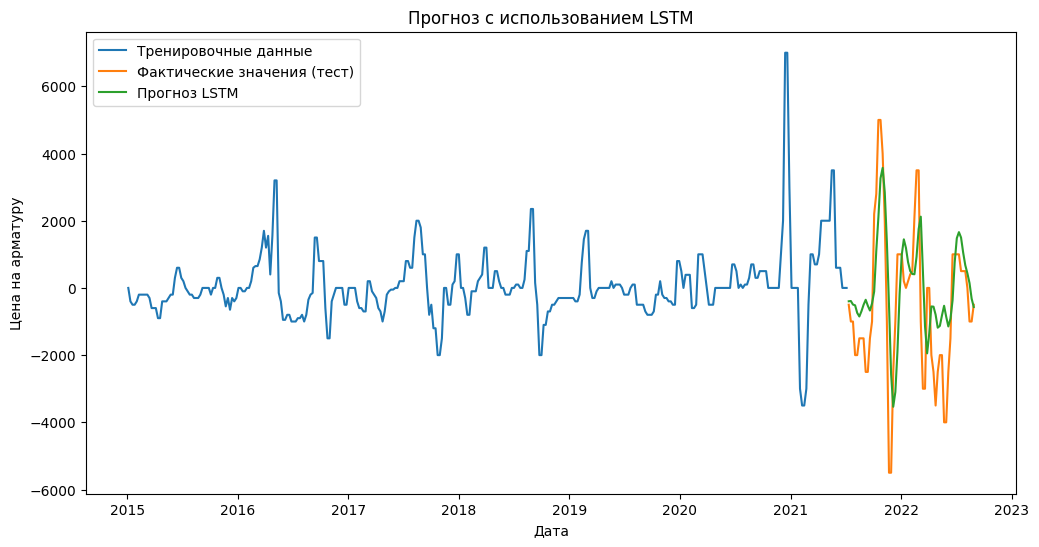

In [42]:
# Подготовка данных для визуализации
train_dates = df_ts['dt'][:train_size_lstm + seq_length]
test_dates = df_ts['dt'].iloc[train_size_lstm + seq_length: train_size_lstm + seq_length + len(y_test)]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(df_ts['dt'][:train_size_lstm + seq_length], scaler.inverse_transform(df_ts[["Цена на арматуру (сглаженная)"]])[:train_size_lstm + seq_length], label="Тренировочные данные")
plt.plot(test_dates, y_test_inv, label="Фактические значения (тест)")
plt.plot(test_dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз с использованием LSTM")
plt.legend()
plt.show()

### смесь 2 моделй

## Лучшая модель